## Background


The goal of this project is to train a multi-objective image classifier using data from [Kaggle](https://www.kaggle.com/jangedoo/utkface-new).

The model should take image as an input and predict the gender and age of the person in the image.

## Import libraries and read in data

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
from typing import List
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import PIL
from PIL import Image, ImageDraw
import torchvision.models as models

from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import WandbLogger  


import os

In [2]:
path = "../input/utkface-new/UTKFace/"
files = os.listdir(path)
print("Total samples:", len(files))
print(files[0])

Total samples: 23708
26_0_2_20170104023102422.jpg.chip.jpg


We can extract the needed labels (age and gender) from the file names. The first number in the file name is age, the second number is gender (0 for male, 1 for female).

In [3]:
import cv2
images = []
ages = []
genders = []
for file in files:
    image = cv2.imread(path+file,0)
    image = cv2.resize(image,dsize=(64,64))
    image = image.reshape((image.shape[0],image.shape[1],1))
    images.append(image)
    split_var = file.split('_')
    ages.append(split_var[0])
    genders.append(int(split_var[1]) )

Now let's put everything into a dataframe and check for missing values.

In [4]:
data = {'img_file': files, 'gender': genders, 'age': ages}
df = pd.DataFrame(data=data)
df['age'] = df['age'].astype(int)
df.head()

,img_file,gender,age
0,26_0_2_20170104023102422.jpg.chip.jpg,0,26
1,22_1_1_20170112233644761.jpg.chip.jpg,1,22
2,21_1_3_20170105003215901.jpg.chip.jpg,1,21
3,28_0_0_20170117180555824.jpg.chip.jpg,0,28
4,17_1_4_20170103222931966.jpg.chip.jpg,1,17


In [5]:
df.isnull().sum()

img_file    0
gender      0
age         0
dtype: int64

## EDA & Preprocessing

Let's start with som simpe EDA and preprocessing: look at some of the images, split age into age groups and look at the age and gender distribution.

First, let's create a dictionary for genders where 0 is male, and 1 is female and print some examples.

In [6]:
gender_map = {
    0: "Male",
    1: "Female"
}

In [7]:
def show_images(df: pd.DataFrame) -> None:
    fig,ax = plt.subplots(2,5)
    fig.set_size_inches(10, 6)
    k =0
    for i in range(2):
        for j in range(5):
            image = cv2.imread(path+df.img_file[k],0)
            image = cv2.resize(image,dsize=(64,64))
            image = image.reshape((image.shape[0],image.shape[1],1))
            
            ax[i,j].imshow(image , cmap='gray')
            ax[i,j].set_title(f'{gender_map[df.gender[k]]}, {df.age[k]}')
            k = k+1;
            
    plt.tight_layout()

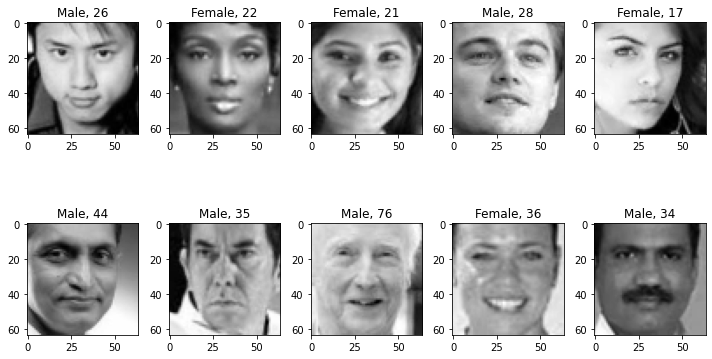

In [8]:
show_images(df)

From the first look, the training data seems to be quite diverse, as it includes people of different races, genders and ages. Let's see how many samples there are for both genders.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


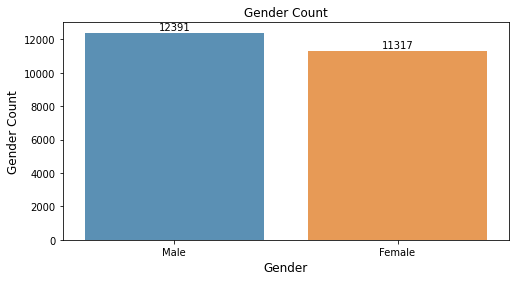

In [9]:
plt.figure(figsize=(8,4))
ax = sns.countplot(df.gender, alpha=0.8)
plt.title("Gender Count")
plt.ylabel('Gender Count', fontsize=12)
plt.xlabel('Gender', fontsize=12)

positions = (0, 1)
labels = ("Male", "Female")
plt.xticks(positions, labels)

#adding the text labels
labels = df.gender.value_counts().sort_index()
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

As we can see, the difference between female and male samples is not that big. Let's see how the age distribution looks. First, we need to find the range of ages and split the ages into age bins.

In [10]:
print("Max age: ", df['age'].max())
print("Max age: ", df['age'].min())

Max age:  116
Max age:  1


In [11]:
df['bin'] = pd.cut(df['age'], bins = [0,10,20,30,40,50,60,70,80,90,100,110,120],
                   labels = ['0s', '10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s', '100s', '110s'])
df.head()

,img_file,gender,age,bin
0,26_0_2_20170104023102422.jpg.chip.jpg,0,26,20s
1,22_1_1_20170112233644761.jpg.chip.jpg,1,22,20s
2,21_1_3_20170105003215901.jpg.chip.jpg,1,21,20s
3,28_0_0_20170117180555824.jpg.chip.jpg,0,28,20s
4,17_1_4_20170103222931966.jpg.chip.jpg,1,17,10s


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


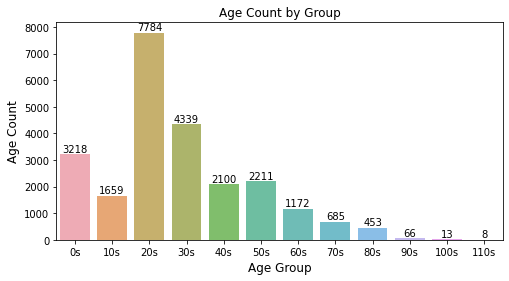

In [12]:
plt.figure(figsize=(8,4))
ax = sns.countplot(df.bin, alpha=0.8)
plt.title("Age Count by Group")
plt.ylabel('Age Count', fontsize=12)
plt.xlabel('Age Group', fontsize=12)

#adding the text labels
rects = ax.patches
labels = df.bin.value_counts().sort_index()
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

As we can see, the age classes are more imbalanced. The majority of people are between 20 and 40 years old. There are only 540 people that are older than 80. Let's see if how the age distribution looks for each gender.

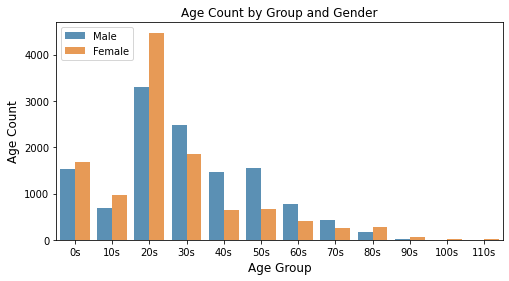

In [13]:
plt.figure(figsize=(8,4))
ax = sns.countplot(df.bin, alpha=0.8, hue=df.gender)
plt.title("Age Count by Group and Gender")
plt.ylabel('Age Count', fontsize=12)
plt.xlabel('Age Group', fontsize=12)
plt.legend(labels=["Male","Female"])
plt.show()

As we can see, the majority of people in their 0s,10s and 20s are women and the majority of people older than 30 are men. Let's split the data into train and validation sets

In [14]:
train, test = train_test_split(files, test_size=0.1, random_state=14)
train, val = train_test_split(files, test_size=0.2, random_state=14)
print("Samples in training set:",len(train))
print("Samples in validation set:",len(val))
print("Samples in testing set:",len(test))

Samples in training set: 18966
Samples in validation set: 4742
Samples in testing set: 2371


## Modeling

Now let's define the image transformations (image resize, center crop, normalize, convert to tensor).

In [15]:
preprocess = transforms.Compose([
   transforms.Resize(64),
   transforms.ToTensor(),
   transforms.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
   )
])

Now let's create a custom dataset that applies the transformations to the images and deals with the labels.

In [16]:
class MultiTaskDataset(Dataset):
    def __init__(self, path: str, files: list, tfms, size: int=64):
        self.files = files
        self.path = path
        self.tfms = tfms
        self.size = size

    def __len__(self): 
        return len(self.files)
    
    def __getitem__(self, idx: int):
        img_file = self.files[idx]
        img = PIL.Image.open(self.path + img_file).convert('RGB')
        img = self.tfms(img)
        
        split_var = self.files[idx].split('_')
        age = int(split_var[0])
        age = torch.tensor(age, dtype=torch.float32)
        gender = torch.tensor(int(split_var[1]), dtype=torch.int64)

        return img, age.log_()/4.75, gender, img_file


In [17]:
train_ds = MultiTaskDataset(path, train, preprocess, size=64)
valid_ds = MultiTaskDataset(path, val, preprocess, size=64)
test_ds = MultiTaskDataset(path, test, preprocess, size=64)

Now we can begin the modeling part. We are going to apply [transfer learning](https://pytorch-lightning.readthedocs.io/en/stable/advanced/transfer_learning.html) using ResNet34. We’ll pack everything in [LightningModule](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html). This is a multi-task learning task, because we have to predict the age and gender based on the input image. Predicting age is a regression problem with a single output, predicting gender is a classification problem with two outputs. With that in mind, we can create the model.

In [18]:
class UTKFaceModel(pl.LightningModule):
    
    def __init__(self):
        super(UTKFaceModel, self).__init__()
        
        backbone = models.resnet34(pretrained=True)       
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)
        
        self.age = nn.Linear(num_filters,1)
        self.gender = nn.Linear(num_filters,2)
 
    def forward(self, x):
        if type(x) != torch.Tensor:
            x = torch.tensor(x)

        self.feature_extractor.eval()
        with torch.no_grad():
            x = self.feature_extractor(x).flatten(1)
        
        age = self.age(x)
        age =  torch.sigmoid(age)

        gender = self.gender(x)
        gender =  nn.functional.softmax(gender)
        return [age, gender]
    
    def forward_for_explainer(self, x):
        if type(x) != torch.Tensor:
            x = torch.tensor(x)     
        x = x.permute(0, 3, 1, 2)
        
        self.feature_extractor.eval()
        with torch.no_grad():
            x = self.feature_extractor(x).flatten(1)
        
        age = self.age(x)
        age =  torch.sigmoid(age)

        gender = self.gender(x)
        gender =  nn.functional.softmax(gender)
        return [age, gender]
    
    
    def training_step(self, batch: dict, batch_idx: int ):
        img, age, gender, img_file = batch
        preds = self.forward(img)
        loss_age = nn.functional.mse_loss(preds[0], age)
        loss_gender = nn.functional.cross_entropy(preds[1],gender)
        self.log_dict(
            {'train_loss': loss_age+loss_gender,
             'age_train_loss': loss_age,
             'gender_train_loss': loss_gender,
            'batch': batch_idx},
             prog_bar=True, logger=True
        )
        return loss_age+loss_gender
    
    def validation_step(self, batch: dict, batch_idx: int):
        img, age, gender, img_file = batch
        preds = self.forward(img)
        
        loss_age = nn.functional.mse_loss(preds[0], age)
        loss_gender = nn.functional.cross_entropy(preds[1],gender)
        self.log_dict(
            {'val_loss': loss_age+loss_gender,
             'age_val_loss': loss_age,
             'gender_val_loss': loss_gender,
            'batch': batch_idx},
             prog_bar=True, logger=True
        )
        return loss_age+loss_gender

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)
    
    def train_dataloader(self):
        return DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
    
    def val_dataloader(self):
        return DataLoader(valid_ds, batch_size=32, shuffle=False, num_workers=4)

In [19]:
model = UTKFaceModel()
wandb_logger = WandbLogger(name='UTKFace', project='UTKFace', entity='dovilezal') 

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [20]:
trainer = pl.Trainer(logger=wandb_logger,
                     max_epochs = 5)
trainer.fit(model)

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Training: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  "Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2"


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Evaluation

Finally, it's time to evaluate the model performance. First we need to call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. 

In [21]:
trainer.test()
model = model.eval()


images = []
img_files = []
predictions_gender = []
predictions_gender_proba = []
labels_gender = []

predictions_age = []
labels_age = []

with torch.no_grad():
    for image, age, gender, img_file in DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=4):
        preds = model.forward(image)
        images.append(image)
        img_files += img_file
        
        gender_proba = preds[1]
        y_gender = torch.argmax(gender_proba, axis=1)
        y_gender_proba = torch.max(gender_proba, axis=1)
        predictions_gender.append(y_gender)
        predictions_gender_proba.append(y_gender_proba.values)
        labels_gender.append(gender)
        
        age_proba = preds[0]
        y_age = torch.exp(age_proba*4.75)
        predictions_age.append(y_age)
        age_label = torch.exp(age*4.75)
        labels_age.append(age_label)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Now we need concatenate results from the batches into one and convert it into numpy arrays and create a dataframe.

In [22]:
predictions_gender = torch.cat(predictions_gender)
labels_gender = torch.cat(labels_gender)

predictions_gender = predictions_gender.numpy()
predictions_gender_proba = torch.cat(predictions_gender_proba)
labels_gender = labels_gender.numpy()

In [23]:
predictions_age = torch.cat(predictions_age)
labels_age = torch.cat(labels_age)

predictions_age = predictions_age.numpy()
labels_age = labels_age.numpy()

In [24]:
data = {'img_file': img_files, 'gender_label': labels_gender, 'gender_prediction': predictions_gender,
        'gender_prediction_proba': predictions_gender_proba, 'age_label': labels_age.astype(int), 
        'age_prediction': predictions_age.flatten().astype(int)}
df = pd.DataFrame(data=data)
df['age_difference'] = abs(df['age_prediction'] - df['age_label'])
df.head()

,img_file,gender_label,gender_prediction,gender_prediction_proba,age_label,age_prediction,age_difference
0,1_0_0_20161219203503252.jpg.chip.jpg,0,1,0.852005,1,23,22
1,40_0_3_20170119175434618.jpg.chip.jpg,0,0,0.988392,40,26,14
2,54_0_0_20170117191341090.jpg.chip.jpg,0,0,0.950670,54,21,33
3,15_0_0_20170110231550866.jpg.chip.jpg,0,1,0.892258,15,26,11
4,25_0_2_20170116161907519.jpg.chip.jpg,0,0,0.803271,25,25,0


Let's look at some of the predictions.

In [25]:
def show_images(df: pd.DataFrame) -> None:
    fig,ax = plt.subplots(2,5)
    fig.set_size_inches(10, 6)
    k =0
    for i in range(2):
        for j in range(5):
            image = cv2.imread(path+df.iloc[k,0],0)
            ax[i,j].imshow(image , cmap='gray')
            ax[i,j].set_title(f'Prediction: {gender_map[df.iloc[k,2]]}, {int(df.iloc[k,5])}'+
                              f' \n Label:  {gender_map[df.iloc[k,1]]}, {int(df.iloc[k,4])}')
            k = k+1;
    fig.suptitle('Sample Predictions', fontsize=16)        
    plt.tight_layout()

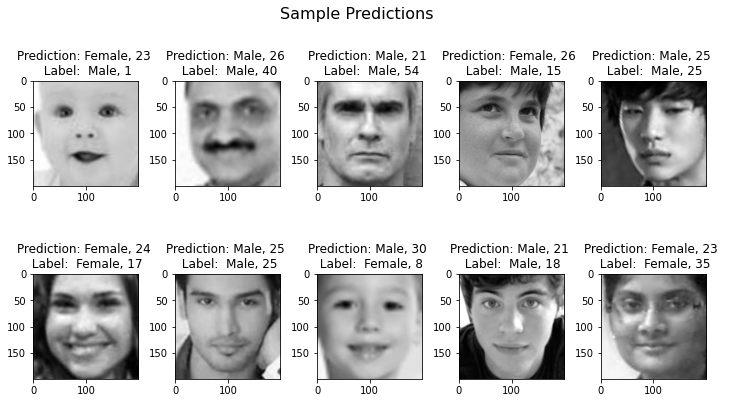

In [26]:
show_images(df)

As we can see from these examples, the model seems to predict the gender way better than the age. Let's see at the gender [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html). 

In [27]:
from sklearn.metrics import classification_report
print('Gender predictions')
classification_report = classification_report(df.gender_label, df.gender_prediction)
print(classification_report)

Gender predictions
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      1252
           1       0.79      0.83      0.81      1119

    accuracy                           0.82      2371
   macro avg       0.82      0.82      0.82      2371
weighted avg       0.82      0.82      0.82      2371



To get a better understanding, we could also look at the confusion matrix.

Text(0.5, 1.0, 'Gender Confusion Matrix')

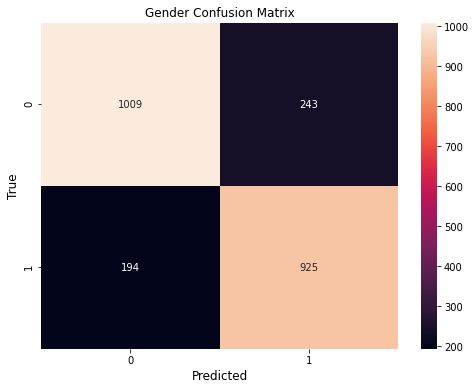

In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(df.gender_label, df.gender_prediction)
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(np.round(conf_mat, 2)), annot=True, fmt='g')
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.title("Gender Confusion Matrix", fontsize=12)

As we can see, the model correctly predicted gender most of the time. Let's print 10 best and 10 worst gender predictions based on the probability.

In [29]:
def show_best_worst_gender_predictions(df: pd.DataFrame, type: str = 'best') -> None:
    if type == 'best':
        top_ten = df.loc[(df['gender_label'] == df['gender_prediction'])].sort_values(
            by=['gender_prediction_proba'], ascending=False).head(10)
        
        image_files = top_ten['img_file'].tolist()
    elif type == 'worst':
        top_ten = df.loc[(df['gender_label'] != df['gender_prediction'])].sort_values(
            by=['gender_prediction_proba'], ascending=False).head(10)
        image_files = top_ten['img_file'].tolist()
    else:
        print('Select one of the types: best or worst')
        return
    
    fig,ax = plt.subplots(2,5)
    fig.set_size_inches(10, 6)
    k =0
    for i in range(2):
        for j in range(5):
            image = cv2.imread(path+image_files[k],0)
            ax[i,j].imshow(image , cmap='gray')
            ax[i,j].set_title(f'Prediction: {gender_map[int(top_ten.iloc[k, 2])]}'+
                              f' \n Label: {gender_map[int(top_ten.iloc[k, 1])]}' +
                             f' \n Probability: {float("{:.2f}".format(top_ten.iloc[k, 3]))}')
            k = k+1;
    fig.suptitle(f'{type.capitalize()} Gender Predictions', fontsize=16)
    plt.tight_layout()

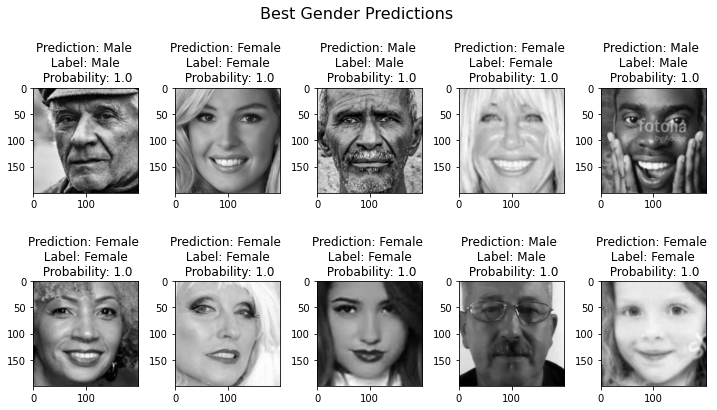

In [30]:
show_best_worst_gender_predictions(df, 'best')

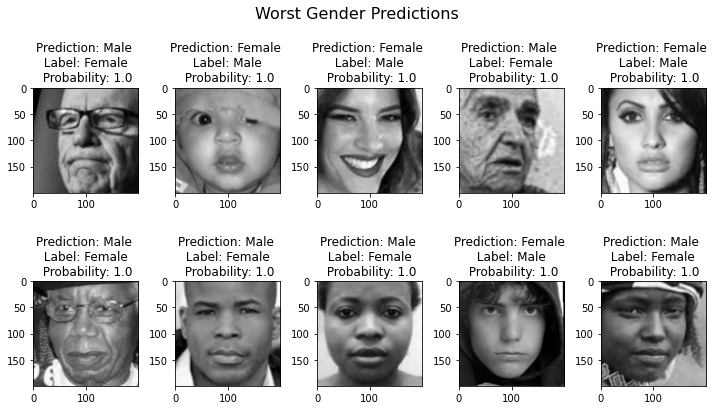

In [31]:
show_best_worst_gender_predictions(df, 'worst')

From some of the examples we can clearly see that some of the images were mislabelled. The model also had truble identifying gender of old people and kids.



Now let's get a better look at the age predictions by printing 10 best and 10 worst predictions.

In [32]:
def show_best_worst_age_predictions(df: pd.DataFrame, type: str = 'best') -> None:
    if type == 'best':
        top_ten = df.sort_values(by=['age_difference'], ascending=True).head(10)
        image_files = top_ten['img_file'].tolist()
    elif type == 'worst':
        top_ten = df.sort_values(by=['age_difference'], ascending=False).head(10)
        image_files = top_ten['img_file'].tolist()
    else:
        print('Select one of the types: best or worst')
        return
    
    fig,ax = plt.subplots(2,5)
    fig.set_size_inches(10, 6)
    k =0
    for i in range(2):
        for j in range(5):
            image = cv2.imread(path+image_files[k],0)
            ax[i,j].imshow(image , cmap='gray')
            ax[i,j].set_title(f'Prediction: {int(top_ten.iloc[k, 5])}'+
                              f' \n Label: {int(top_ten.iloc[k, 4])}')
            k = k+1;
    fig.suptitle(f'{type.capitalize()} Age Predictions', fontsize=16)
    plt.tight_layout()

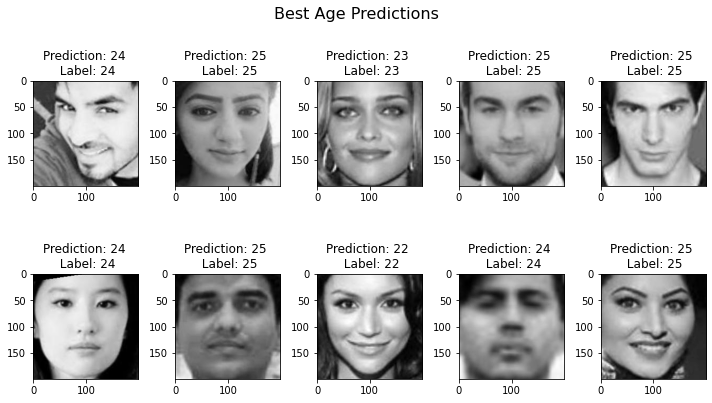

In [33]:
show_best_worst_age_predictions(df, 'best')

As we can see, there are examples where the model correctly predicted the age. All of the people seem to be young. Let's see how many correct predictions the model has made.

In [34]:
correct_age_predictions = len(df.loc[df['age_difference'] == 0])
print(f'Number of correct age predictions: {correct_age_predictions}')
print(f'Percentage of correct age predictions: {correct_age_predictions / len(df) * 100} %' )

Number of correct age predictions: 92
Percentage of correct age predictions: 3.88021931674399 %


In [35]:
less_than_five_age_predictions = len(df.loc[df['age_difference'] <= 5])
print(f'Number of predictions where the difference is less than 5: {less_than_five_age_predictions}')
print(f'Percentage of predictions where the difference is less than 5: {less_than_five_age_predictions / len(df) * 100} %')

Number of predictions where the difference is less than 5: 755
Percentage of predictions where the difference is less than 5: 31.843104175453398 %


In [36]:
df['age_difference'].describe()

count    2371.000000
mean       15.990721
std        14.718165
min         0.000000
25%         4.000000
50%        12.000000
75%        24.000000
max        80.000000
Name: age_difference, dtype: float64

- There are only 63 (2,6%) correct age predictions.
- 761 (32%) predictions are within the 5 years range of the real age.
- The average prediction and label difference is 15 years.

Now let's look at the worst age predictions.

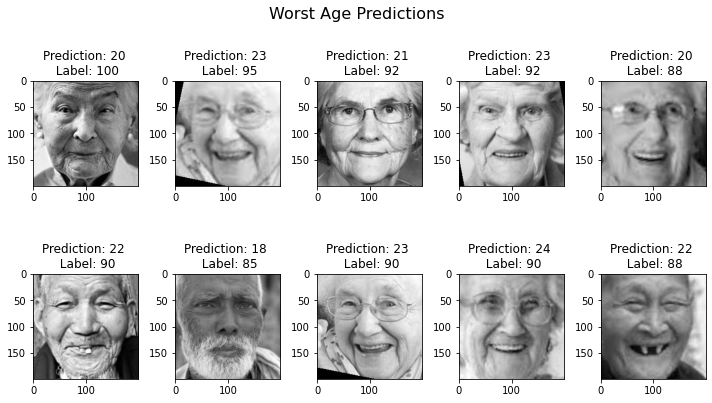

In [37]:
show_best_worst_age_predictions(df, 'worst')

It seems that the model has problems with identifying old people. Let's see how many old people are in the test and train datasets.

In [38]:
old_people = len(df.loc[df['age_label'] >= 80])
print(f'Number of people above 80 years old: {old_people}')
print(f'Percentage of people above 80 years old: {old_people / len(df) * 100} %')

Number of people above 80 years old: 66
Percentage of people above 80 years old: 2.7836355967946016 %


In [39]:
train_ages = []
for file in train:
    split_var = file.split('_')
    train_ages.append(split_var[0])
    
filtered_list = list(filter(lambda x: int(x) >= 80,train_ages))
print(f'Number of people above 80 years old in the training set: {len(filtered_list)}')
print(f'Percentage of people above 80 years old in the training set: {len(filtered_list) / len(train) * 100} %')

Number of people above 80 years old in the training set: 546
Percentage of people above 80 years old in the training set: 2.8788358114520722 %


Less than 3% of the images contain people that are above 80 years old. Let's look at some of the regression metrics.

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print('Mean Squared error: ', mean_squared_error(df['age_label'], df['age_prediction']))
print('Root Mean Squared error: ', mean_squared_error(df['age_label'], df['age_prediction'],squared=False))
print('Mean Absolute error: ', mean_absolute_error(df['age_label'], df['age_prediction']))

Mean Squared error:  472.23618726275834
Root Mean Squared error:  21.73099600254803
Mean Absolute error:  15.990721214677352


## LIME Explainer

Finally, let's use [LIME](https://lime-ml.readthedocs.io/en/latest/lime.html) to see how the model makes predictions. For this, we are going to use two images: one of the images that the model found difficult to predict and one that model predicted correctly.

First we need to preproceess the image and rearranges the dimensions of an array.

In [41]:
img_good_prediction = '22_1_4_20170103223649399.jpg.chip.jpg'
img_bad_prediction = '52_1_0_20170104212301653.jpg.chip.jpg'

In [42]:
preprocess = transforms.Compose([
   transforms.Resize(64),
   transforms.ToTensor(),
])

In [43]:
sample_good = PIL.Image.open(path+img_good_prediction)
sample_good = preprocess(sample_good)
sample_good.shape

torch.Size([3, 64, 64])

In [44]:
sample_bad = PIL.Image.open(path+img_bad_prediction)
sample_bad = preprocess(sample_bad)
sample_bad.shape

torch.Size([3, 64, 64])

In [45]:
sample_good_permuted = sample_good.permute(1, 2, 0)
sample_bad_permuted = sample_bad.permute(1, 2, 0)
sample_good_permuted.shape, sample_bad_permuted.shape

(torch.Size([64, 64, 3]), torch.Size([64, 64, 3]))

Text(0.5, 1.0, 'Prediction: Male, 25\n Label: Female, 52')

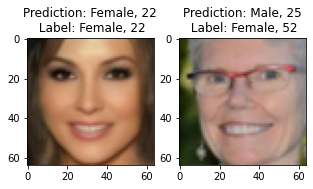

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,5))
ax1.imshow(sample_good_permuted)
ax1.set_title('Prediction: Female, 22'+
                '\n Label: Female, 22')

ax2.imshow(sample_bad_permuted)
ax2.set_title('Prediction: Male, 25'+
                '\n Label: Female, 52')

In [47]:
import lime
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('slic', n_segments=100, compactness=1, sigma=1, start_label=1)

In [48]:
def gender_predict(image):
    model.eval()
    preds = model.forward_for_explainer(image)
    gender_proba = preds[1]
    y_gender = torch.argmax(gender_proba, axis=1)
    return gender_proba.detach().numpy()

In [49]:
def age_predict(image):
    model.eval()
    preds = model.forward_for_explainer(image)
    age_proba = preds[0]
    y_age = torch.exp(age_proba*4.75)
    return y_age.detach().numpy()

In [50]:
age_predict(sample_bad_permuted.unsqueeze(0))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


array([[20.523315]], dtype=float32)

In [51]:
%%time
explanation_gender_good = explainer.explain_instance(np.array(sample_good_permuted),
                                         gender_predict, hide_color=0, num_samples=10000, segmentation_fn=segmenter)
explanation_gender_bad = explainer.explain_instance(np.array(sample_bad_permuted),
                                         gender_predict, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


  0%|          | 0/10000 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


CPU times: user 5min 3s, sys: 2.41 s, total: 5min 6s
Wall time: 2min 32s


In [52]:
%%time
explanation_age_good = explainer.explain_instance(np.array(sample_good_permuted),
                                         age_predict, hide_color=0, num_samples=10000, segmentation_fn=segmenter)
explanation_age_bad = explainer.explain_instance(np.array(sample_bad_permuted),
                                         age_predict, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


  0%|          | 0/10000 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


CPU times: user 5min 4s, sys: 2.33 s, total: 5min 6s
Wall time: 2min 33s


Let's see how the model predicts age.

(-0.5, 63.5, 63.5, -0.5)

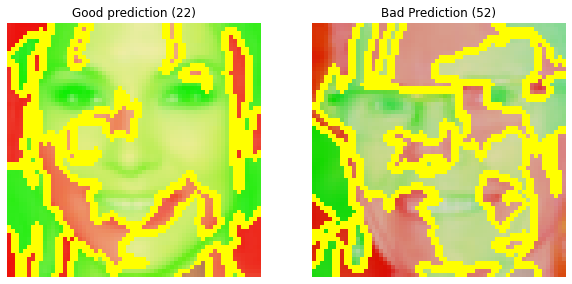

In [53]:
temp_good, mask_good = explanation_age_good.get_image_and_mask(explanation_age_good.top_labels[0],
                                                       positive_only=False, num_features=100, hide_rest=False)
temp_bad, mask_bad = explanation_age_bad.get_image_and_mask(explanation_age_bad.top_labels[0],
                                                       positive_only=False, num_features=100, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(mark_boundaries(temp_good, mask_good))
ax1.set_title('Good prediction (22)')
ax2.imshow(mark_boundaries(temp_bad, mask_bad))
ax2.set_title('Bad Prediction (52)')
ax1.axis('off')
ax2.axis('off')

Now let's see how the model made gender prediction for this image.

(-0.5, 63.5, 63.5, -0.5)

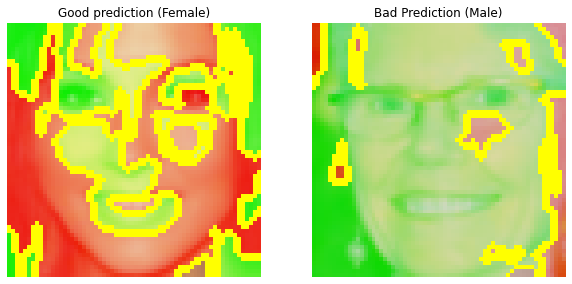

In [54]:
temp_good, mask_good = explanation_gender_good.get_image_and_mask(explanation_gender_good.top_labels[0],
                                                       positive_only=False, num_features=100, hide_rest=False)
temp_bad, mask_bad = explanation_gender_bad.get_image_and_mask(explanation_gender_bad.top_labels[0],
                                                       positive_only=False, num_features=100, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(mark_boundaries(temp_good, mask_good))
ax1.set_title('Good prediction (Female)')
ax2.imshow(mark_boundaries(temp_bad, mask_bad))
ax2.set_title('Bad Prediction (Male)')
ax1.axis('off')
ax2.axis('off')

As we can see, when the model is making good predictions, it focuses on specific features (e.g. eyes, nose, lips). When the prediction is wrong, the model focused on almost the whole face and didn't identify specific parts.

## Conclusion

- Only ~33% of age predictions are within the 5 years range of the real age.
- The model has problems predicting the age and gender of old people. This is due to insufficient images of old people in the training set.
- The model is also not very accurate with babies for the same reasons. 
- There is some incorrectly labeled data. The results could improve if it was fixed.